In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import scipy.special
from numbers import Number

import math
from torch.distributions.kl import register_kl

from tqdm.notebook import tqdm

from src.model.models import MLP
from src.data.helpers import list_to_model, get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [140]:
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)

        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]*np.pi/180

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx])

        return weights, angle

In [141]:
class IveFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, v, z):

        assert isinstance(v, Number), "v must be a scalar"

        self.save_for_backward(z)
        self.v = v
        z_cpu = z.data.cpu().numpy()

        if np.isclose(v, 0):
            output = scipy.special.i0e(z_cpu, dtype=z_cpu.dtype)
        elif np.isclose(v, 1):
            output = scipy.special.i1e(z_cpu, dtype=z_cpu.dtype)
        else:  #  v > 0
            output = scipy.special.ive(v, z_cpu, dtype=z_cpu.dtype)
        #         else:
        #             print(v, type(v), np.isclose(v, 0))
        #             raise RuntimeError('v must be >= 0, it is {}'.format(v))

        return torch.Tensor(output).to(z.device)

    @staticmethod
    def backward(self, grad_output):
        z = self.saved_tensors[-1]
        return (
            None,
            grad_output * (ive(self.v - 1, z) - ive(self.v, z) * (self.v + z) / z),
        )


class Ive(torch.nn.Module):
    def __init__(self, v):
        super(Ive, self).__init__()
        self.v = v

    def forward(self, z):
        return ive(self.v, z)


ive = IveFunction.apply


##########
# The below provided approximations were provided in the
# respective source papers, to improve the stability of
# the Bessel fractions.
# I_(v/2)(k) / I_(v/2 - 1)(k)

# source: https://arxiv.org/pdf/1606.02008.pdf
def ive_fraction_approx(v, z):
    # I_(v/2)(k) / I_(v/2 - 1)(k) >= z / (v-1 + ((v+1)^2 + z^2)^0.5
    return z / (v - 1 + torch.pow(torch.pow(v + 1, 2) + torch.pow(z, 2), 0.5))


# source: https://arxiv.org/pdf/1902.02603.pdf
def ive_fraction_approx2(v, z, eps=1e-20):
    def delta_a(a):
        lamb = v + (a - 1.0) / 2.0
        return (v - 0.5) + lamb / (
            2 * torch.sqrt((torch.pow(lamb, 2) + torch.pow(z, 2)).clamp(eps))
        )

    delta_0 = delta_a(0.0)
    delta_2 = delta_a(2.0)
    B_0 = z / (
        delta_0 + torch.sqrt((torch.pow(delta_0, 2) + torch.pow(z, 2))).clamp(eps)
    )
    B_2 = z / (
        delta_2 + torch.sqrt((torch.pow(delta_2, 2) + torch.pow(z, 2))).clamp(eps)
    )

    return (B_0 + B_2) / 2.0


In [142]:
class HypersphericalUniform(torch.distributions.Distribution):

    support = torch.distributions.constraints.real
    has_rsample = False
    _mean_carrier_measure = 0

    @property
    def dim(self):
        return self._dim

    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, val):
        self._device = val if isinstance(val, torch.device) else torch.device(val)

    def __init__(self, dim, validate_args=None, device="cpu"):
        super(HypersphericalUniform, self).__init__(
            torch.Size([dim]), validate_args=validate_args
        )
        self._dim = dim
        self.device = device

    def sample(self, shape=torch.Size()):
        output = (
            torch.distributions.Normal(0, 1)
            .sample(
                (shape if isinstance(shape, torch.Size) else torch.Size([shape]))
                + torch.Size([self._dim + 1])
            )
            .to(self.device)
        )

        return output / output.norm(dim=-1, keepdim=True)

    def entropy(self):
        return self.__log_surface_area()

    def log_prob(self, x):
        return -torch.ones(x.shape[:-1], device=self.device) * self.__log_surface_area()

    def __log_surface_area(self):
        if torch.__version__ >= "1.0.0":
            lgamma = torch.lgamma(torch.tensor([(self._dim + 1) / 2]).to(self.device))
        else:
            lgamma = torch.lgamma(
                torch.Tensor([(self._dim + 1) / 2], device=self.device)
            )
        return math.log(2) + ((self._dim + 1) / 2) * math.log(math.pi) - lgamma


class VonMisesFisher(torch.distributions.Distribution):

    arg_constraints = {
        "loc": torch.distributions.constraints.real,
        "scale": torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        # option 1:
        return self.loc * (
            ive(self.__m / 2, self.scale) / ive(self.__m / 2 - 1, self.scale)
        )
        # option 2:
        # return self.loc * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # options 3:
        # return self.loc * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

    @property
    def stddev(self):
        return self.scale

    def __init__(self, loc, scale, validate_args=None, k=1):
        self.dtype = loc.dtype
        self.loc = loc
        self.scale = scale
        self.device = loc.device
        self.__m = loc.shape[-1]
        self.__e1 = (torch.Tensor([1.0] + [0] * (loc.shape[-1] - 1))).to(self.device)
        self.k = k

        super().__init__(self.loc.size(), validate_args=validate_args)

    def sample(self, shape=torch.Size()):
        with torch.no_grad():
            return self.rsample(shape)

    def rsample(self, shape=torch.Size()):
        shape = shape if isinstance(shape, torch.Size) else torch.Size([shape])

        w = (
            self.__sample_w3(shape=shape)
            if self.__m == 3
            else self.__sample_w_rej(shape=shape)
        )

        v = (
            torch.distributions.Normal(0, 1)
            .sample(shape + torch.Size(self.loc.shape))
            .to(self.device)
            .transpose(0, -1)[1:]
        ).transpose(0, -1)
        v = v / v.norm(dim=-1, keepdim=True)

        w_ = torch.sqrt(torch.clamp(1 - (w ** 2), 1e-10))
        x = torch.cat((w, w_ * v), -1)
        z = self.__householder_rotation(x)

        return z.type(self.dtype)

    def __sample_w3(self, shape):
        shape = shape + torch.Size(self.scale.shape)
        u = torch.distributions.Uniform(0, 1).sample(shape).to(self.device)
        self.__w = (
            1
            + torch.stack(
                [torch.log(u), torch.log(1 - u) - 2 * self.scale], dim=0
            ).logsumexp(0)
            / self.scale
        )
        return self.__w

    def __sample_w_rej(self, shape):
        c = torch.sqrt((4 * (self.scale ** 2)) + (self.__m - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.__m - 1)

        # using Taylor approximation with a smooth swift from 10 < scale < 11
        # to avoid numerical errors for large scale
        b_app = (self.__m - 1) / (4 * self.scale)
        s = torch.min(
            torch.max(
                torch.tensor([0.0], dtype=self.dtype, device=self.device),
                self.scale - 10,
            ),
            torch.tensor([1.0], dtype=self.dtype, device=self.device),
        )
        b = b_app * s + b_true * (1 - s)

        a = (self.__m - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.__m - 1) * math.log(self.__m - 1)

        self.__b, (self.__e, self.__w) = b, self.__while_loop(b, a, d, shape, k=self.k)
        return self.__w

    @staticmethod
    def first_nonzero(x, dim, invalid_val=-1):
        mask = x > 0
        idx = torch.where(
            mask.any(dim=dim),
            mask.float().argmax(dim=1).squeeze(),
            torch.tensor(invalid_val, device=x.device),
        )
        return idx

    def __while_loop(self, b, a, d, shape, k=20, eps=1e-20):
        #  matrix while loop: samples a matrix of [A, k] samples, to avoid looping all together
        b, a, d = [
            e.repeat(*shape, *([1] * len(self.scale.shape))).reshape(-1, 1)
            for e in (b, a, d)
        ]
        w, e, bool_mask = (
            torch.zeros_like(b).to(self.device),
            torch.zeros_like(b).to(self.device),
            (torch.ones_like(b) == 1).to(self.device),
        )

        sample_shape = torch.Size([b.shape[0], k])
        shape = shape + torch.Size(self.scale.shape)

        while bool_mask.sum() != 0:
            con1 = torch.tensor((self.__m - 1) / 2, dtype=torch.float64)
            con2 = torch.tensor((self.__m - 1) / 2, dtype=torch.float64)
            e_ = (
                torch.distributions.Beta(con1, con2)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            u = (
                torch.distributions.Uniform(0 + eps, 1 - eps)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            w_ = (1 - (1 + b) * e_) / (1 - (1 - b) * e_)
            t = (2 * a * b) / (1 - (1 - b) * e_)

            accept = ((self.__m - 1.0) * t.log() - t + d) > torch.log(u)
            accept_idx = self.first_nonzero(accept, dim=-1, invalid_val=-1).unsqueeze(1)
            accept_idx_clamped = accept_idx.clamp(0)
            # we use .abs(), in order to not get -1 index issues, the -1 is still used afterwards
            w_ = w_.gather(1, accept_idx_clamped.view(-1, 1))
            e_ = e_.gather(1, accept_idx_clamped.view(-1, 1))

            reject = accept_idx < 0
            accept = ~reject if torch.__version__ >= "1.2.0" else 1 - reject

            w[bool_mask * accept] = w_[bool_mask * accept]
            e[bool_mask * accept] = e_[bool_mask * accept]

            bool_mask[bool_mask * accept] = reject[bool_mask * accept]

        return e.reshape(shape), w.reshape(shape)

    def __householder_rotation(self, x):
        u = self.__e1 - self.loc
        u = u / (u.norm(dim=-1, keepdim=True) + 1e-5)
        z = x - 2 * (x * u).sum(-1, keepdim=True) * u
        return z

    def entropy(self):
        # option 1:
        output = (
            -self.scale
            * ive(self.__m / 2, self.scale)
            / ive((self.__m / 2) - 1, self.scale)
        )
        # option 2:
        # output = - self.scale * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # option 3:
        # output = - self.scale * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

        return output.view(*(output.shape[:-1])) + self._log_normalization()

    def log_prob(self, x):
        return self._log_unnormalized_prob(x) - self._log_normalization()

    def _log_unnormalized_prob(self, x):
        output = self.scale * (self.loc * x).sum(-1, keepdim=True)

        return output.view(*(output.shape[:-1]))

    def _log_normalization(self):
        output = -(
            (self.__m / 2 - 1) * torch.log(self.scale)
            - (self.__m / 2) * math.log(2 * math.pi)
            - (self.scale + torch.log(ive(self.__m / 2 - 1, self.scale)))
        )

        return output.view(*(output.shape[:-1]))


@register_kl(VonMisesFisher, HypersphericalUniform)
def _kl_vmf_uniform(vmf, hyu):
    return -vmf.entropy() + hyu.entropy()


In [143]:
class Autoencoder(torch.nn.Module):
    
    def __init__(self, distribution='normal'):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(Autoencoder, self).__init__()
        
        self.distribution = distribution
        self.activation = F.relu
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(33, 1024)
        self.fc_e1 = nn.Linear(1024, 1024)
        self.fc_e2 = nn.Linear(1024, 512)
        self.fc_e3 = nn.Linear(512, 256)
        self.fc_e4 = nn.Linear(256, 16)
        self.fc_e5 = nn.Linear(16, 16)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(16, 16)
            self.fc_var =  nn.Linear(16, 16)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(16, 16)
            self.fc_var = nn.Linear(16, 1)
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(16, 16)
        self.fc_d1 = nn.Linear(16, 256)
        self.fc_d2 = nn.Linear(256, 512)
        self.fc_d3 = nn.Linear(512, 1024)
        self.fc_d4 = nn.Linear(1024, 1024)
        self.fc_logits = nn.Linear(1024, 33)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        x = self.activation(self.fc_e2(x))
        x = self.activation(self.fc_e3(x))
        x = self.activation(self.fc_e4(x))
        x = self.activation(self.fc_e5(x))
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.activation(self.fc_d2(x))
        x = self.activation(self.fc_d3(x))
        x = self.activation(self.fc_d4(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(16 - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_

In [144]:
config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

autoencoder = Autoencoder("vmf")
loss_fn = torch.nn.MSELoss()
latent_loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)


dataset_name = "../data/eight_angles_small.csv"
path = f"../models/autoencoders/svae"

dataset = ModelParamsDataset(dataset_name, 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [145]:
autoencoder.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        optimizer.zero_grad()

        _, (q_z, p_z), _, output = autoencoder(X)
        loss = loss_fn(output, X)
        if autoencoder.distribution == 'normal':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
        elif autoencoder.distribution == 'vmf':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
        
        loss = loss + loss_KL
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Projects\Python\master-thesis\venv\Lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class '__main__.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Epoch: 1, Loss: 4.972157955169678
Epoch: 6, Loss: 5.0149641036987305
Epoch: 11, Loss: 5.080051898956299
Epoch: 16, Loss: 4.917148590087891
Epoch: 21, Loss: 4.999096870422363
Epoch: 26, Loss: 5.0197529792785645
Epoch: 31, Loss: 5.119753360748291
Epoch: 36, Loss: 5.111515998840332
Epoch: 41, Loss: 4.977527618408203
Epoch: 46, Loss: 5.001458644866943
Epoch: 51, Loss: 5.068692684173584
Epoch: 56, Loss: 5.0469279289245605


KeyboardInterrupt: 

c:\Projects\Python\master-thesis\venv\Lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class '__main__.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


(80000, 16)
(80000, 3)


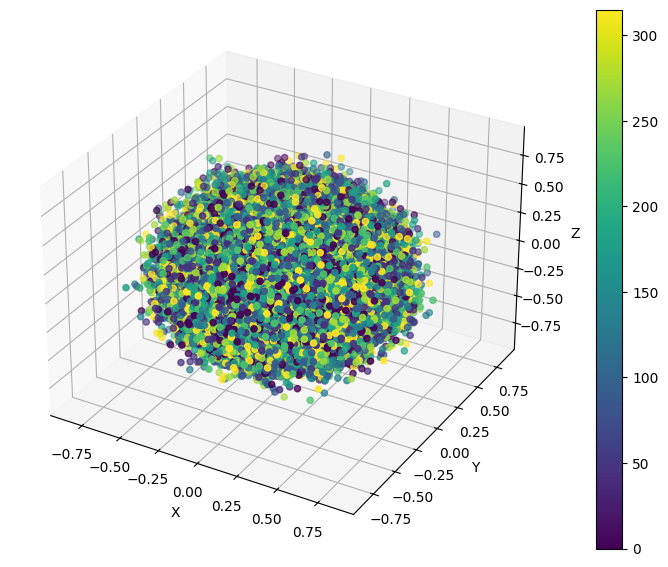

In [148]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder("vmf")
autoencoder.load_state_dict(torch.load("{}/autoencoder_55.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

_, _, latent, _ = autoencoder(torch.tensor(weights).float())
latent = latent.detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()